# Model

In [1]:
import sys
import os
sys.path.append("/home/lauro/code/msc-thesis/svgd/kernel_learning")
enable_float64 = False
from jax.config import config
config.update("jax_enable_x64", enable_float64)
# config.update("jax_log_compiles", True)
# config.update('jax_disable_jit', True)
config.update("jax_debug_nans", True)
import json_tricks as json
import copy
from tqdm import tqdm

import jax.numpy as np
from jax import grad, jit, vmap, random, lax, jacfwd
from jax import lax
from jax.ops import index_update, index
import matplotlib.pyplot as plt
import numpy as onp
import jax
import pandas as pd
import haiku as hk

import config

import utils
import metrics
import time
import plot
import stein
import kernels
import distributions
import kernel_learning

from jax.experimental import optimizers

key = random.PRNGKey(0)

/home/lauro/.virtualenvs/msc-thesis/lib/python3.8/site-packages/jax/lib/xla_bridge.py:125: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [2]:
target = distributions.Gaussian(0, 0.1)
proposal = distributions.Gaussian(0, 5)
n_particles = 200
n_iter = 40
n_iter_kernel = 20
svgd_lr = 0.05
kernel_lr = 0.1
sizes = [1]

key, subkey, svgd_key = random.split(key, 3)
# key, subkey, svgd_key = random.split(key, 3)
# key, subkey, svgd_key = random.split(key, 3)
learner = kernel_learning.AdversarialSVGD(subkey, target, proposal, sizes, svgd_lr=svgd_lr, kernel_lr=kernel_lr, svgd_key=svgd_key, n_particles=n_particles)

In [3]:
def makeplots(svgd, kernel_learner=None, sep_groups=False):
    fig, axs = plt.subplots(2, 2, figsize=[18, 10])
    n_steps = svgd.step_counter
    stepgrid = np.arange(n_steps)
    
    axs = axs.flatten()
    ax=axs[0]
    if sep_groups:
        for idx, name in zip(svgd.group_idx, [gn + " Histogram" for gn in ("Leader", "Follower")]):
            ax.hist(svgd.get_params()[idx, 0], density=True, bins=25, label=name, alpha=0.5)
    else:
        ax.hist(svgd.get_params()[:, 0], density=True, bins=25)
    ax.plot(svgd.get_params(), np.exp(svgd.loglikelihood), ".", label="Likelihood")
    plot.plot_fun(svgd.target.pdf, lims=ax.get_xlim(), ax=ax, label="Target")
    
    ax=axs[1]
    if sep_groups:
        ax.plot(stepgrid, svgd.rundata["leader_variance"],   "--o", label="Leader Variance")
        ax.plot(svgd.rundata["follower_variance"], "--o", label="Follower Variance")
    else:
        ax.plot(svgd.rundata["leader_variance"], "--o", label="Leader Variance")

    ax.set_xlabel("Step")
    
    if kernel_learner is not None:
        ax.plot(np.linspace(0, n_steps, n_steps*n_iter_kernel), kernel_learner.rundata["bandwidth"], label="bandwidth")    
    
    ax=axs[2]
    ax.plot(stepgrid[:-1], -onp.diff(svgd.rundata["KL"]), "--o", label="KL diff")
    ax.plot(stepgrid, np.array(svgd.rundata["KSD"]) * svgd_lr, "--o", label="KSD * stepsize")
    ax.set_yscale("log")
    for ax in axs: 
        ax.legend()


In [4]:
learner.flow_and_train(n_iter=n_iter, n_iter_kernel=n_iter_kernel)

100%|██████████| 40/40 [00:09<00:00,  4.18it/s]


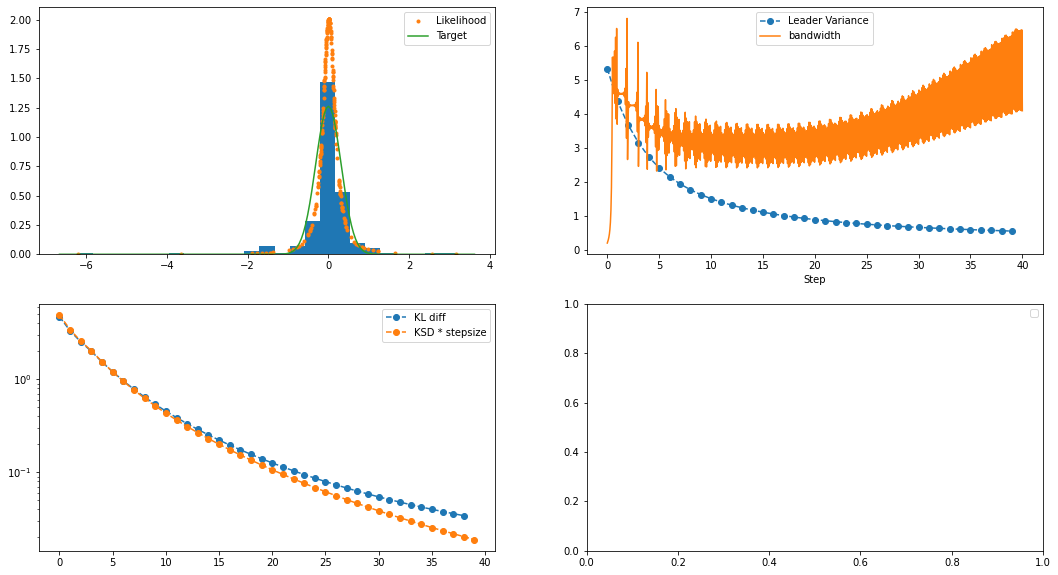

In [5]:
makeplots(learner.svgd, learner.kernel)

## compare vanilla

In [6]:
# key, subkey = random.split(key)

In [7]:
s = kernel_learning.SVGD(
    svgd_key, target, proposal, n_particles, learning_rate=svgd_lr, 
    get_kernel=lambda par: kernels.get_rbf_kernel(1.)
)

In [8]:
s.flow(n_iter=n_iter)

100%|██████████| 40/40 [00:05<00:00,  7.22it/s]


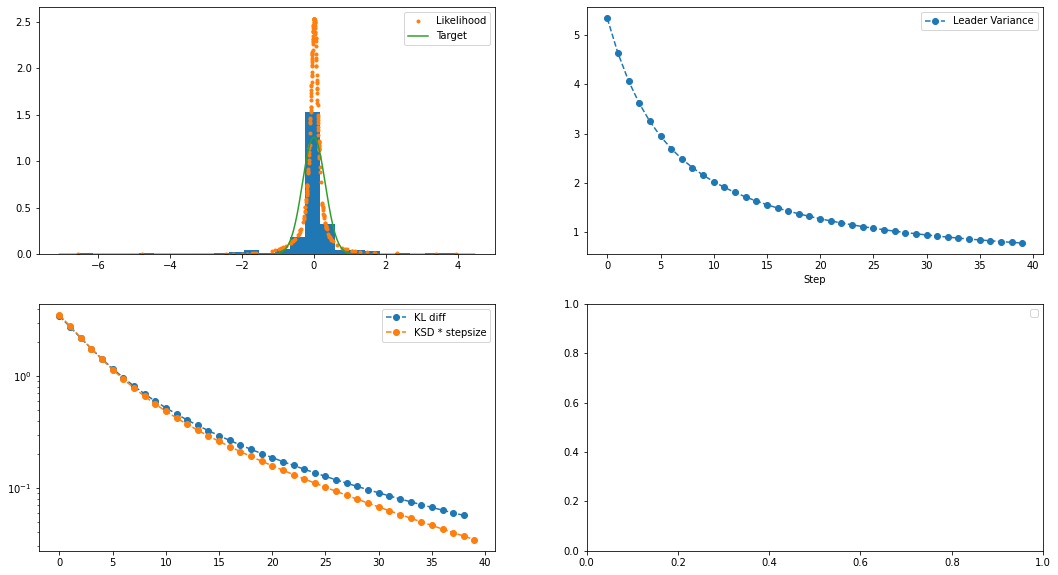

In [9]:
makeplots(s)

## compare $h = var$

In [10]:
# key, subkey = random.split(key)
s2 = kernel_learning.SVGD(svgd_key, target, proposal, n_particles, learning_rate=svgd_lr, get_kernel=kernels.get_rbf_kernel)

In [11]:
h = 1
for _ in tqdm(range(n_iter)):
    s2.step(h)
    particles = s2.get_params()
    h = np.var(particles)

100%|██████████| 40/40 [00:07<00:00,  5.21it/s]


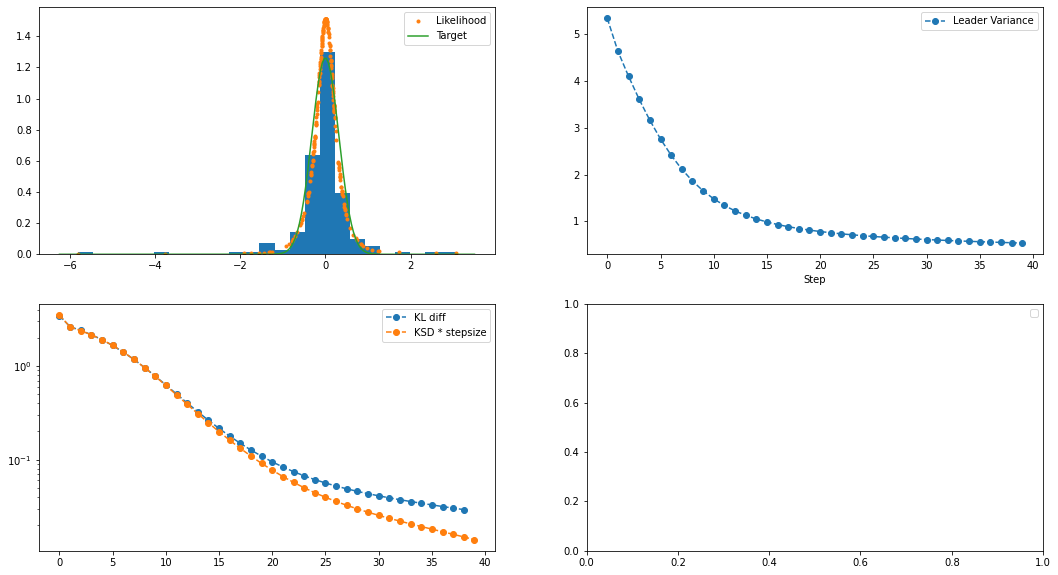

In [12]:
makeplots(s2)

## Final score

In [13]:
print("Trained bandwidth:", learner.svgd.rundata["KL"][-1])
print("Fixed bandwidth:", s.rundata["KL"][-1])
print("Adaptive b=var:", s2.rundata["KL"][-1])

Trained bandwidth: 2.0181112
Fixed bandwidth: 3.1106098
Adaptive b=var: 1.8038656
